In [845]:
from sklearn.feature_extraction.text import CountVectorizer
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import matplotlib.ticker as ticker
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
import re

In [846]:
text_df = pd.read_csv("../data/data_sample.csv")
text_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0


In [847]:
text_df = text_df[["text"]]
text_df["text"] = text_df["text"].astype(str)

In [848]:
text_df.dropna(inplace=True)
text_df.isna().sum()

text    0
dtype: int64

In [849]:
text_df.head(10)

,text
0,@AppleSupport causing the reply to be disregar...
1,@105835 Your business means a lot to us. Pleas...
2,@76328 I really hope you all change but I'm su...
3,@105836 LiveChat is online at the moment - htt...
4,@VirginTrains see attached error message. I've...
5,"@105836 Have you tried from another device, Mi..."
6,"@VirginTrains yep, I've tried laptop too sever..."
7,"@105836 It's working OK from here, Miriam. Doe..."
8,@VirginTrains I still haven't heard &amp; the ...
9,@105836 That's what we're here for Miriam 😊 T...


In [850]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    93 non-null     object
dtypes: object(1)
memory usage: 872.0+ bytes


In [851]:
text_df["text"] = text_df["text"].str.lower().str.strip()
text_df.head()

,text
0,@applesupport causing the reply to be disregar...
1,@105835 your business means a lot to us. pleas...
2,@76328 i really hope you all change but i'm su...
3,@105836 livechat is online at the moment - htt...
4,@virgintrains see attached error message. i've...


In [852]:
AUTHOR_PATTERN = re.compile(r"^@\S+ ")

def remove_author(text):
    return re.sub(AUTHOR_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_author)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i'm sure you ...
3,livechat is online at the moment - https://t.c...
4,see attached error message. i've tried leaving...


In [853]:
HTTP_PATTERN = re.compile(r"https?://\S+|www\.\S+ ")

def remove_http(text):
    return re.sub(HTTP_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_http).str.strip()
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i'm sure you ...
3,livechat is online at the moment - or contact...
4,see attached error message. i've tried leaving...


In [854]:
HTML_PATTERN = re.compile('<.*?>')

def remove_html(text):
    return re.sub(HTML_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_html)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i'm sure you ...
3,livechat is online at the moment - or contact...
4,see attached error message. i've tried leaving...


In [855]:
text_df["text"] = text_df["text"].str.replace("\n", " ")
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i'm sure you ...
3,livechat is online at the moment - or contact...
4,see attached error message. i've tried leaving...


In [856]:
text_df["text"] = text_df["text"].str.replace("’", "'")
APOSTROPHES = {
    "'m":    "i am",
    "'re":   "are",
    "'ve":   "have",
    "'ll":   "will",
    "'d":    "would",
    "n't":   "not",
    "won't": "will not",
    "can't": "cannot",
}

def convert_apostrophes(text):
    for apostrophe, value in APOSTROPHES.items():
        text = re.sub(u'('+apostrophe+')', f' {value} ', text)
    return text

text_df["text"] = text_df["text"].apply(convert_apostrophes)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i i am sure ...
3,livechat is online at the moment - or contact...
4,see attached error message. i have tried leav...


In [857]:
ABBREVIATIONS = {}

with open("../data/abbr.txt", 'r') as f:
    for line in f.readlines():
        line = line.lower().strip().replace(",", "")
        k, v = line.split("=")
        ABBREVIATIONS.update({k: v})

def convert_abbreviations(text):
    return " ".join([
        ABBREVIATIONS[w] if w in ABBREVIATIONS else w
        for w in text.split()
    ])

text_df["text"] = text_df["text"].apply(convert_abbreviations)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i i am sure y...
3,livechat is online at the moment - or contact ...
4,see attached error message. i have tried leavi...


In [858]:
NUMBER_PATTERN = re.compile(r"\d*")

def remove_numbers(text):
    return re.sub(NUMBER_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_numbers)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us. please dm you...
2,i really hope you all change but i i am sure y...
3,livechat is online at the moment - or contact ...
4,see attached error message. i have tried leavi...


In [859]:
PUNCTUATION_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))

text_df["text"] = text_df["text"].apply(remove_punctuation)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us please dm your...
2,i really hope you all change but i i am sure y...
3,livechat is online at the moment or contact ...
4,see attached error message i have tried leavin...


In [860]:
EMOT_EMOJI = {
    emoji: value.replace(":", "").replace(",", "").replace(" ", "_").lower()
    for emoji, value in {**EMOTICONS_EMO, **UNICODE_EMOJI}.items()
}

def convert_emot_emoji(text):
    for emoji, value in EMOT_EMOJI.items():
        text = re.sub(u'('+re.escape(emoji)+')', f" {value}", text)
    return text

text_df["text"] = text_df["text"].apply(convert_emot_emoji)
text_df.head()

,text
0,causing the reply to be disregarded and the ta...
1,your business means a lot to us please dm your...
2,i really hope you all change but i i am sure y...
3,livechat is online at the moment or contact ...
4,see attached error message i have tried leavin...


In [861]:
ENG_PATTERN = re.compile(r"^[a-z_ ]*$")

def extract_eng(text):
    return not re.match(ENG_PATTERN, text)

text_df["text"].copy().apply(extract_eng).sum()

0

In [862]:
STOPWORDS = stopwords.words("english")

def remove_stopwords(text):
    return " ".join(w for w in nltk.word_tokenize(text) if not w in STOPWORDS)

text_df["text"] = text_df["text"].apply(remove_stopwords)
text_df.head()

,text
0,causing reply disregarded tapped notification ...
1,business means lot us please dm name zip code ...
2,really hope change sure wo
3,livechat online moment contact option leave me...
4,see attached error message tried leaving voice...


In [863]:
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for w in text.split():
        if w in misspelled_words:
            corrected_text.append(spell.correction(w))
        else:
            corrected_text.append(w)
    return " ".join(corrected_text)

text_df["text"] = text_df["text"].apply(correct_spellings)
text_df.head()

,text
0,causing reply disregarded tapped notification ...
1,business means lot us please do name zip code ...
2,really hope change sure wo
3,likethat online moment contact option leave me...
4,see attached error message tried leaving voice...


In [864]:
# Для текущего датасета предпочтительно использовать лемматизацию в виду
# большого количества сложных слов, которые требуют более тщательной обработки,
# что отражается на скорости обработки данных

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

text_df["text"] = text_df["text"].apply(lemmatize_words)
text_df.head()

,text
0,causing reply disregarded tapped notification ...
1,business mean lot u please do name zip code ad...
2,really hope change sure wo
3,likethat online moment contact option leave me...
4,see attached error message tried leaving voice...


In [865]:
# Часто встречающиеся слова в датасете
cnt = Counter()
for text in text_df["text"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(10)

[('u', 25),
 ('help', 20),
 ('do', 19),
 ('thanks', 13),
 ('please', 11),
 ('would', 10),
 ('phone', 9),
 ('version', 9),
 ('hi', 9),
 ('io', 8)]

In [866]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

def remove_freqwords(text):
    return " ".join([w for w in str(text).split() if w not in FREQWORDS])

text_df["text"] = text_df["text"].apply(remove_freqwords)
text_df.head()

,text
0,causing reply disregarded tapped notification ...
1,business mean lot name zip code additional det...
2,really hope change sure wo
3,likethat online moment contact option leave me...
4,see attached error message tried leaving voice...


In [867]:
# Редко встречающиеся слова в датасете
num_rare_words = 20
cnt.most_common()[:-num_rare_words-1:-1]

[('lee', 1),
 ('log', 1),
 ('including', 1),
 ('line', 1),
 ('green', 1),
 ('thin', 1),
 ('keen', 1),
 ('slowdown', 1),
 ('huge', 1),
 ('faves', 1),
 ('item', 1),
 ('removing', 1),
 ('cumbersome', 1),
 ('layout', 1),
 ('finding', 1),
 ('bit', 1),
 ('chris', 1),
 ('ty', 1),
 ('responding', 1),
 ('speed', 1)]

In [868]:
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-num_rare_words-1:-1]])

def remove_rarewords(text):
    return " ".join([w for w in str(text).split() if w not in RAREWORDS])

text_df["text"] = text_df["text"].apply(remove_rarewords)
text_df.head()

,text
0,causing reply disregarded tapped notification ...
1,business mean lot name zip code additional det...
2,really hope change sure wo
3,likethat online moment contact option leave me...
4,see attached error message tried leaving voice...


In [869]:
# Разделение на тестовую и обучающую выборки
train_data, test_data = train_test_split(text_df["text"], train_size=0.8)

In [870]:
# Векторизация текста на основе частоты каждого слова
count_vect = CountVectorizer(analyzer='word')
count_terms= count_vect.fit_transform(train_data)
count_tokens = count_vect.get_feature_names_out()
count_terms_vect = count_vect.transform(test_data)

df_count_vect = pd.DataFrame(data = count_terms_vect.todense(), columns = count_tokens)
df_count_vect

,ac,account,adam,address,advise,affect,affinity,age,air,aircraft,...,whatsapp,wifi,winking_face,wish,without,wo,work,working,yall,yard
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [871]:
df_count_vect_sum = df_count_vect.sum()
print(f'Наиболее часто встречающееся слово в датасете: {df_count_vect_sum.idxmax()} - {df_count_vect_sum.max()}')

Наиболее часто встречающееся слово в датасете: amp - 3


In [872]:
df_count_vect.describe()

,ac,account,adam,address,advise,affect,affinity,age,air,aircraft,...,whatsapp,wifi,winking_face,wish,without,wo,work,working,yall,yard
count,19.0,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.0,19.0,...,19.000000,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
mean,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,...,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.315302,0.0,0.0,0.0,0.0,0.0,0.229416,0.0,0.0,...,0.229416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


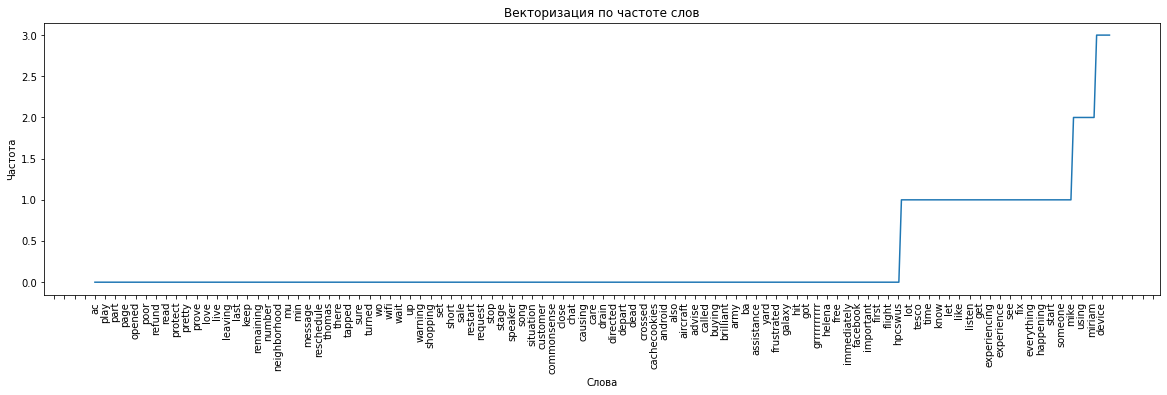

In [873]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot()
ax.set_xlabel('Слова')
ax.set_ylabel('Частота')
ax.set_title("Векторизация по частоте слов")
ax.xaxis.set_major_locator(ticker.MultipleLocator(df_count_vect.shape[1] / 100))
plt.xticks(rotation = 90)

plt.plot(df_count_vect_sum.sort_values())